In [1]:
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(system_id=0, points=100):

    with h5py.File("lotka_volterra_data.h5", "r") as f:
        trajectories = f["trajectories"][:]
        time_points = f["time"][:]
        prey = trajectories[system_id, :points, 0]
        predator = trajectories[system_id, :points, 1]
        times = time_points[:points]

    return prey, predator, times

In [3]:
def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer

In [4]:
def scaler(prey, predator, alpha, decimals=3):
    prey = np.array(prey)
    predator = np.array(predator)
    data = np.stack([prey, predator], axis=-1)
    rescaled = data/alpha * 10
    return np.round(rescaled, decimals = decimals)

In [5]:
def encoding(prey, predator):
    series = np.column_stack((prey, predator))
    encoded = ';'.join([','.join(map(str, row)) for row in series])
    return encoded

def decoding(data):
    data = data.replace("<|endoftext|>", "")
    time_steps = data.split(';')
    decoded = np.array([list(map(float, step.split(','))) 
                        for step in time_steps 
                        if step.strip() 
                        and len(step.split(',')) == 2 
                        and all(value.strip() for value in step.split(','))]
                        [:100])
    prey = decoded[:, 0]
    predator = decoded[:, 1]
    return prey, predator

In [6]:
model, tokenizer = load_qwen()

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [7]:
def process_data(system_id=0, points=100, alpha=5, decimals=3):
    prey, predator, times = get_dataset(system_id=system_id, points=points)
    scaled = scaler(prey, predator, alpha = alpha, decimals=decimals)
    new_prey, new_predator = scaled[:, 0], scaled[:, 1] 
    encoded = encoding(new_prey, new_predator)
    tokenized_data = tokenizer(encoded, return_tensors="pt")
    return tokenized_data, encoded, np.column_stack((prey, predator, new_prey, new_predator)), times

In [8]:
example_tokenized_data, example_preprocessed_data = process_data(system_id=700, points=3)[:2]
print("Preprocessed data:", example_preprocessed_data)
print("Tokenized results:", example_tokenized_data["input_ids"].tolist()[0])

Preprocessed data: 2.267,2.206;1.111,2.516;0.51,2.35
Tokenized results: [17, 13, 17, 21, 22, 11, 17, 13, 17, 15, 21, 26, 16, 13, 16, 16, 16, 11, 17, 13, 20, 16, 21, 26, 15, 13, 20, 16, 11, 17, 13, 18, 20]


In [9]:
def generate_data(system_id=0, output_points=100, alpha=5, decimals=3):

    full_tokenized_data, _, full_combined_data, full_times = process_data(system_id=system_id, points=100, alpha=alpha, decimals=decimals)
    
    max_token_length = max(full_tokenized_data["input_ids"].shape[1] + 1, 1200) #1180
    
    actual_prey, actual_predator = full_combined_data[:,2], full_combined_data[:,3]

    tokenized_data = process_data(system_id=system_id, points=output_points)[0]

    model.eval()
    
    with torch.no_grad():
        output = model.generate(tokenized_data["input_ids"], attention_mask = tokenized_data["attention_mask"], max_new_tokens = max_token_length)
    
    prediction = tokenizer.decode(output[0])
    pred_prey, pred_predator = decoding(prediction)
    
    return pred_prey, pred_predator, actual_prey, actual_predator, full_times

In [10]:
random_system_id = np.random.uniform(0, 1000, 1).astype(int)[0]
pred_prey, pred_predator, actual_prey, actual_predator, full_times = generate_data(system_id=random_system_id, output_points=80, alpha=5, decimals=3)

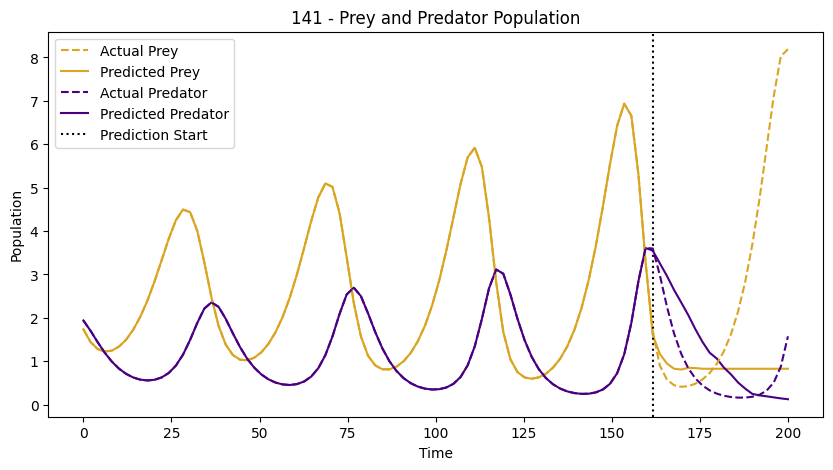

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"{random_system_id} - Prey and Predator Population")
ax.plot(full_times, actual_prey, label="Actual Prey", linestyle="--", zorder=100, color="goldenrod")
ax.plot(full_times, pred_prey, label="Predicted Prey", color="goldenrod")
ax.plot(full_times, actual_predator, label="Actual Predator", linestyle="--", zorder=100, color="indigo")
ax.plot(full_times, pred_predator, label="Predicted Predator", color="indigo")
ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.axvline(full_times[80], color="black", linestyle="dotted", label="Prediction Start")
ax.legend()
plt.show()

In [12]:
print("MEAN PREY SQUARED ERROR:", mean_squared_error(pred_prey, actual_prey))
print("MEAN PREY ABSOLUTE ERROR:", mean_absolute_error(pred_prey, actual_prey))
print("R2 PREY SCORE:", r2_score(pred_prey, actual_prey))
print("MEAN PREDATOR SQUARED ERROR:", mean_squared_error(pred_predator, actual_predator))
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_absolute_error(pred_predator, actual_predator))
print("R2 PREDATOR SCORE:", r2_score(pred_predator, actual_predator))

MEAN PREY SQUARED ERROR: 2.0228214152609327
MEAN PREY ABSOLUTE ERROR: 0.39957004335165025
R2 PREY SCORE: 0.28351167378931774
MEAN PREDATOR SQUARED ERROR: 0.11815923132287846
MEAN PREDATOR ABSOLUTE ERROR: 0.12709002024173738
R2 PREDATOR SCORE: 0.8506389393710891


In [13]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

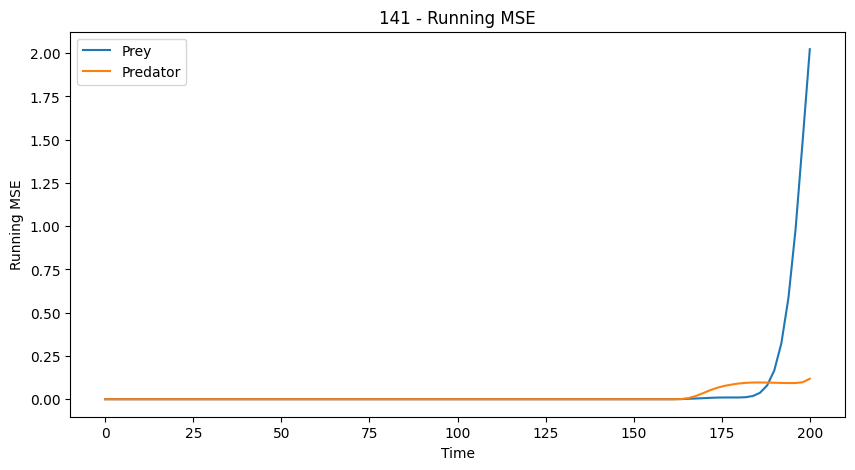

In [14]:
running_mse_prey = running_mse(pred_prey, actual_prey)
running_mse_predator = running_mse(pred_predator, actual_predator)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"{random_system_id} - Running MSE")
ax.plot(full_times, running_mse_prey, label="Prey")
ax.plot(full_times, running_mse_predator, label="Predator")
ax.set_xlabel("Time")
ax.set_ylabel("Running MSE")
ax.legend()
plt.show()

In [15]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [16]:
model.eval()

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [17]:
model.config.to_dict()

{'vocab_size': 151936,
 'max_position_embeddings': 32768,
 'hidden_size': 896,
 'intermediate_size': 4864,
 'num_hidden_layers': 24,
 'num_attention_heads': 14,
 'use_sliding_window': False,
 'sliding_window': 32768,
 'max_window_layers': 21,
 'num_key_value_heads': 2,
 'hidden_act': 'silu',
 'initializer_range': 0.02,
 'rms_norm_eps': 1e-06,
 'use_cache': True,
 'rope_theta': 1000000.0,
 'rope_scaling': None,
 'attention_dropout': 0.0,
 'return_dict': True,
 'output_hidden_states': False,
 'output_attentions': False,
 'torchscript': False,
 'torch_dtype': 'float32',
 'use_bfloat16': False,
 'tf_legacy_loss': False,
 'pruned_heads': {},
 'tie_word_embeddings': True,
 'chunk_size_feed_forward': 0,
 'is_encoder_decoder': False,
 'is_decoder': False,
 'cross_attention_hidden_size': None,
 'add_cross_attention': False,
 'tie_encoder_decoder': False,
 'max_length': 20,
 'min_length': 0,
 'do_sample': False,
 'early_stopping': False,
 'num_beams': 1,
 'num_beam_groups': 1,
 'diversity_penalt

In [ ]:
class Flopper:
    def __init__(self, sequence, model, num_steps_training=None, batch_size=None, use_lora=False, lora_rank=None):
        """
        Constructor for the Flopper class.
        Args:
            sequence: the input sequence to the model
            model: the model to calculate FLOPs for
            num_steps_training: the number of training steps
            batch_size: the batch size
            use_lora: whether to use LoRA
            lora_rank: the rank of the LoRA decomposition
        """
        self.sequence_length = len(sequence)
        self.model = model
        self.model_dict = self.model.config.to_dict()
        self.hidden_size = self.model_dict['hidden_size']
        self.num_layers = self.model_dict['num_hidden_layers']
        self.vocab_size = self.model_dict['vocab_size']
        self.ffw_size = self.model_dict['intermediate_size']
        self.num_heads = self.model_dict['num_attention_heads']
        self.head_dim = self.hidden_size // self.num_heads
        
        if num_steps_training is None:
            num_steps_training = 10000
        if batch_size is None:
            batch_size = 4
        self.num_steps_training = num_steps_training
        self.batch_size = batch_size

        self.use_lora = use_lora
        if self.lora_rank == None:
            self.lora_rank = 8
        self.lora_rank = lora_rank

        self.total_flops = 0
    


    def __str__(self):
        """
        Returns the total number of FLOPs in scientific notation.
        """
        return f"{self.total_flops:.4e}"
    
    def matrix_multiplication(self, m, n, p, bias=False):
        """
        Calculates the number of FLOPs for a matrix multiplication.

        Args:
            m: the number of rows in the first matrix
            n: the number of columns in the first matrix
            p: the number of columns in the second matrix
            bias: whether to include a bias term
        Returns:
            the number of FLOPs
        """
        flops = m*p*(2*n-1)
        if bias:
            flops += m*p
        return flops
    
    def embedding(self):
        """
        Calculates the number of FLOPs for the embedding layer.

        Returns:
            the number of FLOPs
        """
        flops = self.matrix_multiplication(self.hidden_size, self.vocab_size, self.sequence_length, bias=False)
        return flops
    
    def rms_layernorm(self, m, n):
        """
        Calculates the number of FLOPs for the RMS layer normalization.
        
        Args:
            m: the number of rows in the matrix (the hidden size)
            n: the number of columns in the matrix (the sequence length)
        Returns:
            the number of FLOPs
        """
            
        # Compute the RMS:
        flops = (m*n +      #square each element
                 m*n-1 +    #summing of squared elements
                 m +        #multiply by 1/hidden_size
                 m*10       #sqrt
        )
    
        #Layer norm:
        flops += (m*n +     #division by RMS
                  m*n +     #scaling multiplication factor
                  m*n       #shifting addition of epsilon
        )

        return flops
    
    def softmax(self, m):
        """
        Calculates the number of FLOPs for the softmax function.

        Args:
            m: the number of rows/columns for the matrix in the softmax (the sequence length)

        Returns:
            the number of FLOPs
        """

        # reuse exponentials; 10 flops for exp, 1 flop for addition, 1 flop for division
        # 1 addition & division for each element
        # add n-1 times for each column
        flops = m*m*10      #exp for each element
        flops += m*(m-1)    #sum elements addition
        flops += m*m        #division
        return flops
    
    def silu(self, m, n):
        """
        Calculates the number of FLOPs for the SiLU activation function.

        Args:
            m: the number of rows in the matrix (the intermediate size)
            n: the number of columns in the matrix (the sequence length)
        """
        #calculating sigmoid
        flops = 13*n*m      #exp + addition + multiplication + division
        return flops

    def rope(self, m, n):
        """
        Calculates the number of FLOPs for adding the rotational positional embeddings.

        Args:
        
        """
        #cost of adding rotary positional embeddings
        flops = m*n
        return flops

    def lora(self, m, r):
        #self.head_dim, self.sequence_length
        flops = m*m*2*r
        return flops
    
    def multi_head_attention(self):
        # qkv multiplications
        if self.use_lora == False:
            flops = 3 * self.matrix_multiplication(self.sequence_length, self.hidden_size, self.head_dim, bias=True)
        else:
            flops = 2 * self.lora(self.head_dim, self.lora_rank) #for q and v
            flops += self.matrix_multiplication(self.sequence_length, self.hidden_size, self.head_dim, bias=True) #for k
        # attention score (matrix multiplication)
        flops += self.matrix_multiplication(self.sequence_length, self.head_dim, self.sequence_length, bias=False)
        # scaled self-attention (division and sqrt)
        flops += self.sequence_length*self.sequence_length * 1 + 10
        # softmax
        flops += self.softmax(self.sequence_length)
        # linear multiplication of matrices
        flops += self.matrix_multiplication(self.sequence_length, self.head_dim, self.sequence_length, bias=False)
        # per head
        flops *= self.num_heads
        # concatenation has no associated FLOPs, calculating output
        flops += self.matrix_multiplication(self.sequence_length, self.head_dim, self.sequence_length, bias=False)
        return flops

    def ffd(self):
        # rms layer norm
        flops = self.rms_layernorm(self.hidden_size, self.sequence_length)
        # multi head attention
        flops += self.multi_head_attention()
        # rms layer norm
        flops += self.rms_layernorm(self.hidden_size, self.sequence_length)
        # gate projection
        flops += self.matrix_multiplication(self.sequence_length, self.hidden_size, self.ffw_size, bias=False)
        # up projection
        flops += self.matrix_multiplication(self.sequence_length, self.hidden_size, self.ffw_size, bias=False)
        # SiLU
        flops += self.silu(self.ffw_size, self.sequence_length)
        # element-wise multiplication with SiLU activations
        flops += self.sequence_length * self.ffw_size * 1
        # down projection
        flops += self.matrix_multiplication(self.sequence_length, self.ffw_size, self.hidden_size, bias=False)
        # residuals (addition)
        flops += 2 * self.sequence_length * self.hidden_size * 1
        return flops
    
    def forward_pass(self, new_batch_size=None):
        #forward pass
        if new_batch_size is not None:
            batch_size = new_batch_size
        else:
            batch_size = self.batch_size
        # cost of adding the rotational positional embedding
        flops = self.rope(self.hidden_size, self.sequence_length)
        # MLP per layer
        flops += self.num_layers*self.ffd()
        # final rms layernorm
        flops += self.rms_layernorm(self.hidden_size, self.sequence_length)
        # output layer
        flops += self.matrix_multiplication(self.sequence_length, self.hidden_size, self.vocab_size, bias=True)
        # per batch
        flops *= batch_size
        return flops

    def forward_and_back(self):
        return self.forward_pass() + 2*self.forward_pass(new_batch_size=1)
    
    def compute_flops(self):
        self.total_flops = self.num_steps_training*self.forward_and_back()
        return self.total_flops
    
model_flopper = Flopper(np.zeros(512), model, num_steps_training=1, num_batches=1).compute_flops()
model_flopper.compute_flops()
print(model_flopper)

1.3784e+15


In [19]:
totalflops =  (3*Flopper(np.zeros(128), model, num_steps_training=200).compute_flops() 
               + 3*Flopper(np.zeros(512), model, num_steps_training=200).compute_flops() 
               + 9*Flopper(np.zeros(768), model, num_steps_training=200).compute_flops() 
               + Flopper(np.zeros(768), model, num_steps_training=10000).compute_flops()
)

print(f"{totalflops:4e}")

8.454078e+16


In [24]:
def load_and_preprocess(file_path, test_size=0.2, alpha=5, decimals=3, batch_size=5):
   with h5py.File(file_path, "r") as f:
    trajectories = f["trajectories"][:]
    prey = trajectories[:, :, 0]
    predator = trajectories[:, :, 1]

    scaled = scaler(prey, predator, alpha=alpha, decimals=decimals)
    new_prey = scaled[:, :, 0]
    new_predator = scaled[:, :, 1]

    stacked_data = np.stack((new_prey, new_predator), axis=-1)

    # print(stacked_data.shape)

    train_data, temp_data = train_test_split(stacked_data, test_size=test_size, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=True)

    # print(train_data.shape, val_data.shape, test_data.shape)

    data = []

    for d in [train_data, val_data, test_data]:
        prey, predator = d[:, :, 0], d[:, :, 1]
        encoded = [encoding(prey, predator) for prey, predator in zip(prey, predator)]
        # tokenized = tokenizer(encoded, return_tensors="pt", padding=True, padding_side='left')
        data.append(encoded)

    # print(len(data[0]["input_ids"].tolist()), len(data[1]), len(data[2]))
    # print(data[0]["input_ids"].tolist()[0])

    # train_dataset = TensorDataset(torch.tensor(data[0]["input_ids"].tolist()), torch.tensor(data[0]["attention_mask"].tolist()), torch.tensor(train_data))
    # val_dataset = TensorDataset(torch.tensor(data[1]["input_ids"].tolist()), torch.tensor(data[1]["attention_mask"].tolist()), torch.tensor(val_data))
    # test_dataset = TensorDataset(torch.tensor(data[2]["input_ids"].tolist()), torch.tensor(data[2]["attention_mask"].tolist()), torch.tensor(test_data))

    # print(train_dataset.shape, val_dataset.shape, test_dataset.shape)

    # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return data


train, val, test = load_and_preprocess("lotka_volterra_data.h5")

In [21]:
model.eval()
with torch.no_grad():
    for batch, (input_ids_batch, attention_mask_batch, actual_data) in enumerate(train):
        input_ids_batch = input_ids_batch.to(model.device)
        attention_mask_batch = attention_mask_batch.to(model.device)
        output = model.generate(input_ids_batch, attention_mask = attention_mask_batch, max_new_tokens=1200)
        break

In [22]:
pred_prey_batch, pred_predator_batch = decoding(tokenizer.decode(output[0]))

ValueError: x and y must have same first dimension, but have shapes (100,) and (5, 2)

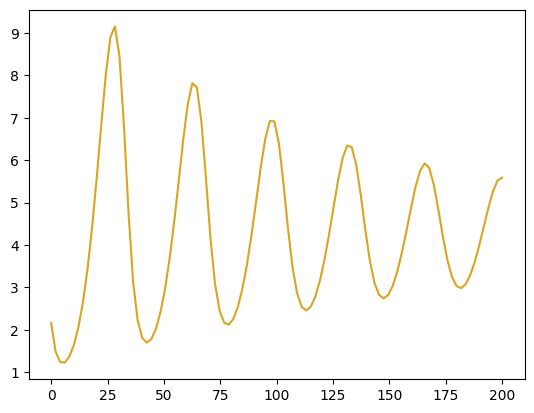

In [23]:
plt.plot(full_times, pred_prey_batch, label="Predicted Prey", color="goldenrod")
plt.plot(full_times, actual_data[:,0])